In [1]:
import wrds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import gc

db = wrds.Connection(wrds_username='asherbaraban')

Loading library list...
Done


In [2]:
# tables = db.list_tables(library='crsp_q_mutualfunds')
# for table in tables:
#     print(table)
#     print(db.describe_table('crsp_q_mutualfunds', table))
#     # print(db.get_table(library="crsp_q_mutualfunds", table=table, obs=100)
# monthly_nav= db.get_table('crsp_q_mutualfunds', 'monthly_nav', obs=100)
"""
            style.si_obj_cd,
            style.wbrger_obj_cd,
            style.policy,
            style.lipper_asset_cd,
            style.lipper_class,
            style.lipper_obj_cd,
"""

df = db.raw_sql("""
        SELECT 
            a.crsp_fundno,
            a.caldt,
            b.mret,
            c.mtna,
            fees.exp_ratio,
            fees.fiscal_yearend,
            fees.begdt,
            fees.enddt,
            fees.turn_ratio,
            names.fund_name,
            ff.cma,
            ff.hml,
            ff.mktrf,
            ff.umd,
            ff.rmw,
            style.crsp_obj_cd,
            style.si_obj_cd,
            style.wbrger_obj_cd,
            style.policy,
            style.lipper_asset_cd,
            style.lipper_class,
            style.lipper_obj_cd,
            header.index_fund_flag
        FROM crsp_q_mutualfunds.monthly_nav a
        LEFT JOIN crsp_q_mutualfunds.monthly_returns b 
            ON a.crsp_fundno = b.crsp_fundno AND a.caldt = b.caldt
        LEFT JOIN crsp_q_mutualfunds.monthly_tna c 
            ON a.crsp_fundno = c.crsp_fundno AND a.caldt = c.caldt
        LEFT JOIN crsp_q_mutualfunds.fund_fees fees
            ON a.crsp_fundno = fees.crsp_fundno AND a.caldt BETWEEN fees.begdt AND fees.enddt
        LEFT JOIN crsp_q_mutualfunds.fund_names names 
            ON a.crsp_fundno = names.crsp_fundno AND a.caldt BETWEEN names.chgdt AND names.chgenddt
        LEFT JOIN ff.fivefactors_monthly ff 
            ON ff.dateff = a.caldt
        LEFT JOIN crsp_q_mutualfunds.fund_style style 
            ON a.crsp_fundno = style.crsp_fundno AND a.caldt BETWEEN style.begdt AND style.enddt
        LEFT JOIN crsp_q_mutualfunds.fund_hdr header
            ON a.crsp_fundno = header.crsp_fundno
        WHERE
            a.caldt >= '1976-09-29' AND a.caldt <= '2024-01-01'
    """)


df['crsp_fundno'] = df['crsp_fundno'].astype(int)
df['caldt'] = pd.to_datetime(df['caldt'])
df['begdt'] = pd.to_datetime(df['begdt'])
df['enddt'] = pd.to_datetime(df['enddt'])
df['fiscal_yearend'] = pd.to_datetime(df['fiscal_yearend'])
df['exp_ratiofiscalyear'] = df['fiscal_yearend'].dt.year
df['month'] = df['caldt'].dt.month
df['year'] = df['caldt'].dt.year
df['crsp_obj_cd'] = df['crsp_obj_cd'].astype(str)
df['index_fund_flag'] = df['index_fund_flag'].astype('category')
df['5year'] = (df['year'] // 5) * 5

df.dtypes

crsp_fundno                     int64
caldt                  datetime64[ns]
mret                          float64
mtna                          float64
exp_ratio                     float64
fiscal_yearend         datetime64[ns]
begdt                  datetime64[ns]
enddt                  datetime64[ns]
turn_ratio                    float64
fund_name                      object
cma                           float64
hml                           float64
mktrf                         float64
umd                           float64
rmw                           float64
crsp_obj_cd                    object
si_obj_cd                      object
wbrger_obj_cd                  object
policy                         object
lipper_asset_cd                object
lipper_class                   object
lipper_obj_cd                  object
index_fund_flag              category
exp_ratiofiscalyear           float64
month                           int32
year                            int32
5year       

In [3]:
id_cols = ['crsp_fundno', 'month', 'year']
# Check if there are any duplicates based on these columns
is_unique_id = not df.duplicated(subset=id_cols).any()

print(f"The columns {id_cols} {'uniquely identify' if is_unique_id else 'do not uniquely identify'} the rows in the DataFrame.")

duplicates = df[df.duplicated(subset=id_cols, keep=False)]
mask = duplicates['year'] == duplicates['exp_ratiofiscalyear']
dedup = duplicates[mask]

unique_check = not dedup.duplicated(subset=id_cols).any()
print(f"The columns {id_cols} {'uniquely identify' if unique_check else 'do not uniquely identify'} the rows in the DataFrame.")


# Remove all of the duplicates and then add back one row per duplicate
df = df.drop(duplicates.index)

df_final = pd.concat([df, dedup])
# For memory purposes
df = None

gc.collect()
df_final.shape

The columns ['crsp_fundno', 'month', 'year'] do not uniquely identify the rows in the DataFrame.
The columns ['crsp_fundno', 'month', 'year'] uniquely identify the rows in the DataFrame.


(8982788, 27)

In [4]:
df_final.sort_values(by=['crsp_fundno', 'year', 'month'], inplace=True)

# Group by 'crsp_fundno' and fill missing values within each group using forward-fill and backward-fill
columns_to_fill = ['exp_ratio', 'fund_name', 'mtna', 'index_fund_flag', 'crsp_obj_cd']
for column in columns_to_fill:
    df_final[column] = df_final.groupby('crsp_fundno')[column].ffill().bfill()

excludes_i_o = ~df_final['crsp_obj_cd'].str.startswith(('OM', 'OC', 'I'), na=False)
# Create a new DataFrame excluding the specified 'crsp_obj_cd' codes
df_final = df_final[excludes_i_o]

regex = 'treas|money m|tax exempt|tax free|municipal|muni |bond fund|fixed income|cash|bond trust|bond index portfolio|mortgage |bond income'
excluded_crsp_fundno = df_final[df_final['fund_name'].str.contains(regex, case=False, na=False)]['crsp_fundno'].unique()
df_final = df_final[~df_final['crsp_fundno'].isin(excluded_crsp_fundno)]

excluded_crsp_fundno = df_final[df_final['lipper_asset_cd'].str.contains(('TX|MB'), case=False, na=False)]['crsp_fundno'].unique()
df_final = df_final[~df_final['crsp_fundno'].isin(excluded_crsp_fundno)]

excluded_crsp_fundno = df_final[df_final['policy'].str.contains(('Bonds|TF|MM|TFM|GS'), case=False, na=False)]['crsp_fundno'].unique()
df_final = df_final[~df_final['crsp_fundno'].isin(excluded_crsp_fundno)]

df_final.shape

(6143289, 27)

In [5]:



df_final[['crsp_obj_cd','wbrger_obj_cd','policy','lipper_asset_cd','lipper_class','lipper_obj_cd', 'fund_name']]['wbrger_obj_cd'].unique()


sorted(df_final['lipper_obj_cd'].dropna().unique())
# df_final[df_final['lipper_obj_cd'] == 'OS']['fund_name']

['ABR',
 'ACF',
 'AE',
 'AED',
 'AGM',
 'ALT',
 'AMS',
 'AU',
 'B',
 'BM',
 'BT',
 'CA',
 'CG',
 'CH',
 'CMD',
 'CN',
 'CS',
 'CV',
 'DL',
 'DSB',
 'EI',
 'EM',
 'EMM',
 'EMN',
 'EMP',
 'EU',
 'FM',
 'FS',
 'FX',
 'G',
 'GFS',
 'GH',
 'GI',
 'GIF',
 'GL',
 'GNR',
 'GRE',
 'GS',
 'GTK',
 'GX',
 'H',
 'I',
 'ID',
 'IF',
 'INR',
 'IRE',
 'IS',
 'JA',
 'LSE',
 'LT',
 'MC',
 'MFF',
 'MR',
 'NR',
 'OS',
 'PC',
 'PS',
 'RE',
 'RR',
 'S',
 'SG',
 'SP',
 'TK',
 'TL',
 'TM',
 'UT',
 'XJ']

In [6]:


unique_fund_names = df_final['fund_name'].unique()

# Define the path to the text file
output_file_path = 'unique_fund_names.txt'

with open(output_file_path, 'w') as file:
    for i in range(0, len(unique_fund_names), 1):
        file.write(unique_fund_names[i] + '\n')

In [7]:
# Group by crsp_fundno and check if any exp_ratio is missing
missing_exp_ratio = df_final.groupby('crsp_fundno')['exp_ratio'].apply(lambda x: x.isnull().any())

# Extract crsp_fundno with missing exp_ratio
crsp_fundnos_with_missing_exp_ratio = missing_exp_ratio[missing_exp_ratio].index.tolist()

print("crsp_fundnos with at least one missing exp_ratio:")
print(crsp_fundnos_with_missing_exp_ratio)

rows_with_missing_exp_ratio = df_final[df_final['crsp_fundno'].isin(crsp_fundnos_with_missing_exp_ratio)]

print("\nRows in the DataFrame with missing exp_ratio:")
rows_with_missing_exp_ratio

missing_exp_ratio = df_final.groupby('crsp_fundno')['exp_ratio'].apply(lambda x: x.isnull().any())

# Extract crsp_fundno with missing exp_ratio
crsp_fundnos_with_missing_exp_ratio = missing_exp_ratio[missing_exp_ratio].index.tolist()

print("crsp_fundnos with at least one missing exp_ratio:")
print(crsp_fundnos_with_missing_exp_ratio)

# Drop rows corresponding to crsp_fundnos with missing exp_ratio
df_final = df_final[~df_final['crsp_fundno'].isin(crsp_fundnos_with_missing_exp_ratio)].copy()
df_final

crsp_fundnos with at least one missing exp_ratio:
[]

Rows in the DataFrame with missing exp_ratio:
crsp_fundnos with at least one missing exp_ratio:
[]


,crsp_fundno,caldt,mret,mtna,exp_ratio,fiscal_yearend,begdt,enddt,turn_ratio,fund_name,...,wbrger_obj_cd,policy,lipper_asset_cd,lipper_class,lipper_obj_cd,index_fund_flag,exp_ratiofiscalyear,month,year,5year
476317,1,1997-02-28,NaN,3.926,0.0019,NaT,NaT,NaT,NaN,AARP Income Tr:Bond for Income,...,None,None,None,None,None,D,NaN,2,1997,1995
56187,1,1997-03-31,-0.011789,12.081,0.0019,NaT,NaT,NaT,NaN,AARP Income Tr:Bond for Income,...,None,None,None,None,None,D,NaN,3,1997,1995
126038,1,1997-04-30,0.008417,20.540,0.0019,NaT,NaT,NaT,NaN,AARP Income Tr:Bond for Income,...,None,None,None,None,None,D,NaN,4,1997,1995
154629,1,1997-05-30,0.013523,26.157,0.0019,NaT,NaT,NaT,NaN,AARP Income Tr:Bond for Income,...,None,None,None,None,None,D,NaN,5,1997,1995
209257,1,1997-06-30,0.012502,34.609,0.0019,NaT,NaT,NaT,NaN,AARP Income Tr:Bond for Income,...,None,None,None,None,None,D,NaN,6,1997,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316875,102616,2023-08-31,-0.013590,NaN,0.0093,2023-09-30,2022-10-01,2023-09-30,1.09,"Atlas US Tactical Income Fund, Inc; Class A Sh...",...,None,None,None,None,None,NaN,2023.0,8,2023,2020
326841,102616,2023-09-29,-0.040420,NaN,0.0093,2023-09-30,2022-10-01,2023-09-30,1.09,"Atlas US Tactical Income Fund, Inc; Class A Sh...",...,None,None,None,None,None,NaN,2023.0,9,2023,2020
336622,102616,2023-10-31,-0.044878,NaN,0.0093,NaT,NaT,NaT,NaN,"Atlas US Tactical Income Fund, Inc; Class A Sh...",...,None,None,None,None,None,NaN,NaN,10,2023,2020
346878,102616,2023-11-30,0.094877,NaN,0.0093,NaT,NaT,NaT,NaN,"Atlas US Tactical Income Fund, Inc; Class A Sh...",...,None,None,None,None,None,NaN,NaN,11,2023,2020


In [8]:
#######################
# Only keep rows where we have mtna and mret
########################

df_final= df_final[df_final['mtna'].notna() & df_final['mret'].notna() & df_final['crsp_obj_cd'].notna()].copy()
df_final.loc[:, 'gross_return'] = df_final['mret'] + (df_final['exp_ratio'] / 12)
df_final.drop(
    columns=['fiscal_yearend', 'begdt', 'enddt', 'exp_ratiofiscalyear'],
    inplace=True)
df_final



,crsp_fundno,caldt,mret,mtna,exp_ratio,turn_ratio,fund_name,cma,hml,mktrf,...,wbrger_obj_cd,policy,lipper_asset_cd,lipper_class,lipper_obj_cd,index_fund_flag,month,year,5year,gross_return
56187,1,1997-03-31,-0.011789,12.081,0.0019,NaN,AARP Income Tr:Bond for Income,0.0166,0.0339,-0.0503,...,None,None,None,None,None,D,3,1997,1995,-0.011631
126038,1,1997-04-30,0.008417,20.540,0.0019,NaN,AARP Income Tr:Bond for Income,-0.0072,0.0007,0.0404,...,None,None,None,None,None,D,4,1997,1995,0.008575
154629,1,1997-05-30,0.013523,26.157,0.0019,NaN,AARP Income Tr:Bond for Income,-0.0296,-0.0413,0.0674,...,None,None,None,None,None,D,5,1997,1995,0.013681
209257,1,1997-06-30,0.012502,34.609,0.0019,NaN,AARP Income Tr:Bond for Income,0.0066,0.0158,0.0410,...,None,None,None,None,None,D,6,1997,1995,0.012660
266556,1,1997-07-31,0.029325,42.490,0.0019,NaN,AARP Income Tr:Bond for Income,-0.0258,0.0026,0.0733,...,None,None,None,None,None,D,7,1997,1995,0.029484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212566,102084,2023-10-31,-0.040743,51.200,0.0000,NaN,Series Portfolios Trust: HW Opportunities MP Fund,-0.0063,0.0017,-0.0318,...,None,None,None,None,None,D,10,2023,2020,-0.040743
232937,102084,2023-11-30,0.061103,51.200,0.0000,NaN,Series Portfolios Trust: HW Opportunities MP Fund,-0.0104,0.0161,0.0884,...,None,None,None,None,None,D,11,2023,2020,0.061103
255159,102084,2023-12-29,0.117412,53.500,0.0000,NaN,Hotchkis and Wiley Funds: HW Opportunities MP ...,0.0136,0.0493,0.0487,...,None,None,EQ,FX,FX,D,12,2023,2020,0.117412
85415,102121,2023-11-30,0.074257,22.600,0.0000,NaN,State Street Institutional Investment Trust: S...,-0.0104,0.0161,0.0884,...,None,None,None,None,None,D,11,2023,2020,0.074257


In [9]:
### FILTER TO OBSERVATIONS BETWEEN APRIL 1961 and December 2009
# lower = pd.Timestamp('1961-04-01')
# upper = pd.Timestamp('2009-12-31') 
# mask = (df['caldt'] >= lower) & (df['caldt'] <= upper)

# df = df.loc[mask]

# num_unique = df['crsp_fundno'].nunique(dropna=False)

# print("Number of unique crsp_fundno's", num_unique)
# df_final
df_final['crsp_fundno'].nunique()

55912

In [10]:
# Adjust mtna for inflation
cpi = db.raw_sql("""
        SELECT
            caldt, cpiind
        FROM crsp_q_indexes.acti
    """)

cpi['caldt'] = pd.to_datetime(cpi['caldt'])
cpi['month'] = cpi['caldt'].dt.month
cpi['year'] = cpi['caldt'].dt.year
cpi.drop(columns=['caldt'], inplace=True)

df_final = df_final.merge(cpi[['year', 'cpiind']], on=['year'])
cpi_target = cpi[(cpi['year'] == 2022) & (cpi['month'] == 12)]['cpiind'].iloc[0]

df_final['mtna_adj2022'] = df_final['mtna'] * (cpi_target / df_final['cpiind'])
df_final = df_final[df_final['mtna_adj2022'] >= 10]
df_final.shape

(4134876, 26)

In [11]:
df_final[['main_fund', 'subclass']] = df_final['fund_name'].str.split('[:/]', n=1, expand=True).apply(lambda x: x.str.strip())
df_final['fund_name'].nunique()

84684

In [12]:
# FIND BENCHMARK VANGUARD PORTFOLIO
vanguard_orthogonal_basis = pd.read_csv('mutual_fund_data/vanguard_orthogonal_basis.csv', index_col=0)

# Make sure the dates are properly formatted and indexed for merging
vanguard_orthogonal_basis.index = pd.to_datetime(vanguard_orthogonal_basis.index)

# Merge orthogonal_basis with df_final on 'caldt'
df_final = df_final.merge(vanguard_orthogonal_basis, left_on='caldt', right_index=True, how='left')

# Define columns to keep from the orthogonal basis
augmented_columns = vanguard_orthogonal_basis.columns.tolist()
columns_to_keep = ['hml', 'umd', 'rmw', 'mktrf', 'cma']

# Group by 'crsp_fundno'
df_grouped = df_final.groupby('crsp_fundno')

# List to store results
results_vanguard = []
results_FF = []
# Compute closest Vanguard-based portfolio and Fama French portfolio
for name, group in df_grouped:
    group_size = len(group)
    if group_size > 24:
        # Only regress on the orthogonal basis factors
        formula = 'gross_return ~ ' + ' + '.join(augmented_columns) + ' + C(year) - 1'
        model = smf.ols(formula, data=group).fit()
        params = model.params
        params = params[augmented_columns]
        params['crsp_fundno'] = name
        params['group_size'] = group_size
        params['nobs'] = model.nobs
        results_vanguard.append(params)

        formula = 'gross_return ~ hml + umd + rmw + mktrf + cma + C(year) - 1'
        model = smf.ols(formula, data=group).fit()
        params = model.params
        params = params[columns_to_keep]
        params['crsp_fundno'] = name
        results_FF.append(params)

# Create DataFrame of results
results_vanguard = pd.DataFrame(results_vanguard)
results_FF = pd.DataFrame(results_FF)
# Merge the regression results back to the complete final DataFrame
df_merged = pd.merge(df_final, results_vanguard, on='crsp_fundno', how='outer', suffixes=('', '_v'))
df_merged = pd.merge(df_merged, results_FF, on='crsp_fundno', how='outer', suffixes=('', '_ff'))

# Clean up memory
df_final = None
gc.collect()

# Calculate the Vanguard-based return using the orthogonal basis
df_merged['vanguard_return'] = 0
for col in augmented_columns:
    df_merged['vanguard_return'] += df_merged[col] * df_merged[f'{col}_v']

# Calculate Vanguard alpha and value added
df_merged['vanguard_alpha'] = df_merged['gross_return'] - df_merged['vanguard_return']
df_merged['vanguard_VA'] = df_merged['vanguard_alpha'] * df_merged['mtna_adj2022'] * 1000000

# Calculate the Fama-French return
df_merged['ff_return'] = (df_merged['hml']*df_merged['hml_ff'] +
                          df_merged['umd']*df_merged['umd_ff'] +
                          df_merged['rmw']*df_merged['rmw_ff'] +
                          df_merged['mktrf']*df_merged['mktrf_ff'] +
                          df_merged['cma']*df_merged['cma_ff'])

# Calculate Fama-French alpha and value added
df_merged['ff_alpha'] = df_merged['gross_return'] - df_merged['ff_return']
df_merged['ff_VA'] = df_merged['ff_alpha'] * df_merged['mtna_adj2022'] * 1000000


In [13]:
print(df_merged.shape)
df_merged.sort_values(by=['crsp_fundno', 'caldt'], inplace=True)

# Define a function to compute the skill ratio for the first 50% observations of each fund
def compute_skill_ratio(group):
    n = len(group)
    half_n = n // 2  # Get the first 50% of the observations
    
    # Ensure there are enough observations to compute the ratio
    if half_n > 1:
        first_half = group.iloc[:half_n]
        mean_vanguard_VA = first_half['vanguard_VA'].mean()
        std_vanguard_VA = first_half['vanguard_VA'].std()
        
        if std_vanguard_VA != 0:
            skill_ratio = mean_vanguard_VA / std_vanguard_VA
        else:
            print(group)
            skill_ratio = np.nan

        return pd.Series({'skill_ratio': skill_ratio})
    else:
        return pd.Series({'skill_ratio': np.nan})

# Group the DataFrame by crsp_fundno and apply the skill ratio computation
skill_ratios = df_merged.groupby('crsp_fundno').apply(compute_skill_ratio).reset_index()

# Merge the skill ratios back to the original DataFrame
df_merged = df_merged.merge(skill_ratios, on='crsp_fundno', how='left')
# Define the file path to save the resulting DataFrame
file_path = 'mutual_fund_data/df_merged.csv'
df_merged.to_csv(file_path, index=False)
print(df_merged.shape)

(4134876, 67)
(4134876, 68)


In [14]:
# Find the benchmark Fama French portfolio
"""
df_grouped = df_final.groupby('crsp_fundno')

results = []
columns_to_keep = ['hml', 'umd', 'rmw', 'mktrf', 'cma']
# Compute closest fama french portfolio
for name, group in df_grouped:
    # for year, data in group.groupby(by='year'):
    formula = 'gross_return ~ hml + umd + rmw + mktrf + cma + C(year) - 1'
    model = smf.ols(formula, data=group).fit()
    params = model.params
    params = params[columns_to_keep]
    params['crsp_fundno'] = name
    results.append(params)

results_df = pd.DataFrame(results)

df_merged = pd.merge(df_final, results_df, on='crsp_fundno', how='outer',
                     suffixes=('', '_b'))
df_final = None
gc.collect()
df_merged['ff_return'] = (df_merged['hml']*df_merged['hml_b'] +
                          df_merged['umd']*df_merged['umd_b'] +
                          df_merged['rmw']*df_merged['rmw_b'] +
                          df_merged['mktrf']*df_merged['mktrf_b'] +
                          df_merged['cma']*df_merged['cma_b'])

df_merged['ff_alpha'] = df_merged['gross_return'] - df_merged['ff_return']
df_merged['ff_VA'] = df_merged['ff_alpha'] * df_merged['mtna_adj2022'] * 1000000

file_path = 'mutual_fund_data/df_merged.csv'

# Write the DataFrame to a CSV file
df_merged.to_csv(file_path, index=False)
"""

df_merged

,crsp_fundno,caldt,mret,mtna,exp_ratio,turn_ratio,fund_name,cma,hml,mktrf,...,rmw_ff,mktrf_ff,cma_ff,vanguard_return,vanguard_alpha,vanguard_VA,ff_return,ff_alpha,ff_VA,skill_ratio
0,1,1997-03-31,-0.011789,12.081,0.0019,NaN,AARP Income Tr:Bond for Income,0.0166,0.0339,-0.0503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1997-04-30,0.008417,20.540,0.0019,NaN,AARP Income Tr:Bond for Income,-0.0072,0.0007,0.0404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1997-05-30,0.013523,26.157,0.0019,NaN,AARP Income Tr:Bond for Income,-0.0296,-0.0413,0.0674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1997-06-30,0.012502,34.609,0.0019,NaN,AARP Income Tr:Bond for Income,0.0066,0.0158,0.0410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1997-07-31,0.029325,42.490,0.0019,NaN,AARP Income Tr:Bond for Income,-0.0258,0.0026,0.0733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4134871,102084,2023-10-31,-0.040743,51.200,0.0000,NaN,Series Portfolios Trust: HW Opportunities MP Fund,-0.0063,0.0017,-0.0318,...,-0.270588,1.110077,-0.027968,-0.059256,0.018512,916966.023374,-0.045098,0.004354,2.156728e+05,0.357641
4134872,102084,2023-11-30,0.061103,51.200,0.0000,NaN,Series Portfolios Trust: HW Opportunities MP Fund,-0.0104,0.0161,0.0884,...,-0.270588,1.110077,-0.027968,0.072565,-0.011462,-567738.107510,0.111414,-0.050311,-2.492048e+06,0.357641
4134873,102084,2023-12-29,0.117412,53.500,0.0000,NaN,Hotchkis and Wiley Funds: HW Opportunities MP ...,0.0136,0.0493,0.0487,...,-0.270588,1.110077,-0.027968,0.107829,0.009583,496001.353888,0.103230,0.014182,7.340524e+05,0.357641
4134874,102121,2023-11-30,0.074257,22.600,0.0000,NaN,State Street Institutional Investment Trust: S...,-0.0104,0.0161,0.0884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


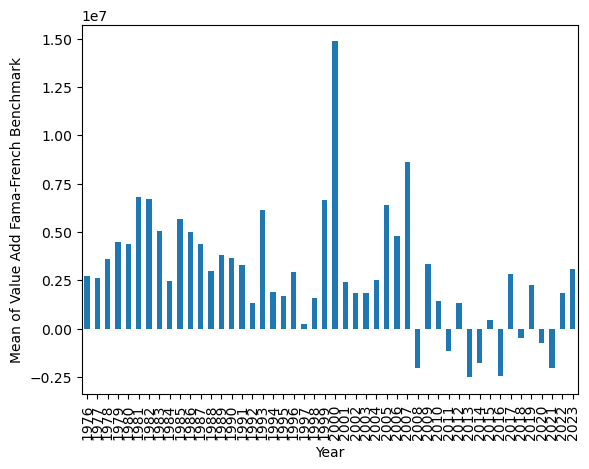

In [15]:
# Group by year and sum ff_va
df_sums = df_merged.groupby('year')['ff_VA'].mean()

# Plot
df_sums.plot(kind='bar')

# Add labels and show plot
plt.xlabel('Year')
plt.ylabel('Mean of Value Add Fama-French Benchmark')
plt.show()

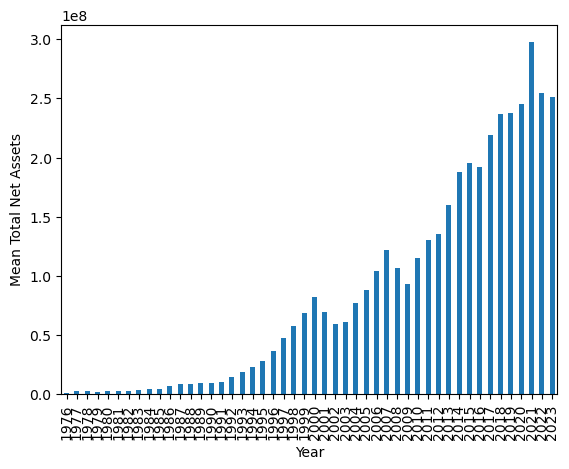

In [16]:
df_means = df_merged.groupby('year')['mtna_adj2022'].sum()
df_means.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Mean Total Net Assets')
plt.show()

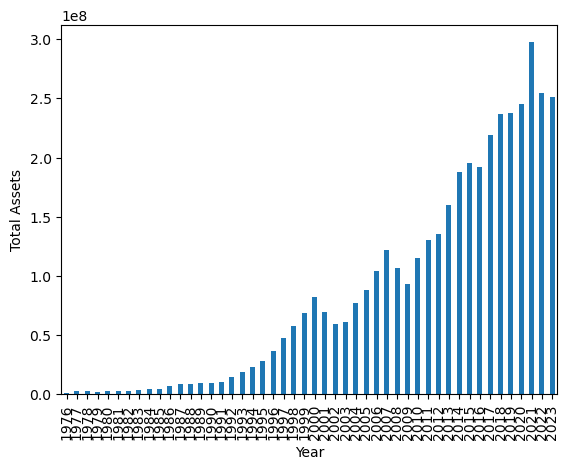

In [17]:
df_means = df_merged.groupby('year')['mtna_adj2022'].sum()
df_means.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Total Assets')
plt.show()

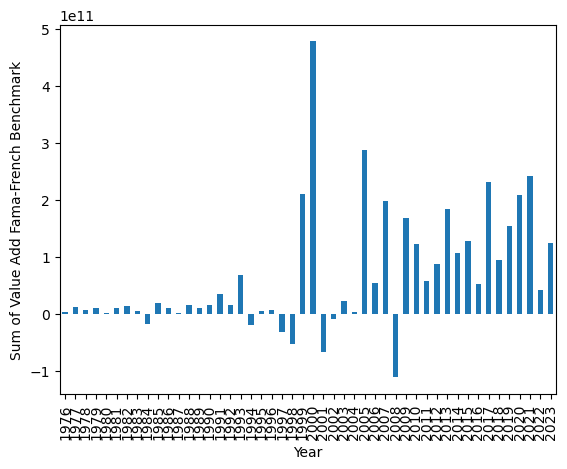

In [18]:
# Group by year and sum ff_va
df_sums = df_merged.groupby('year')['vanguard_VA'].sum()

# Plot
df_sums.plot(kind='bar')

# Add labels and show plot
plt.xlabel('Year')
plt.ylabel('Sum of Value Add Fama-French Benchmark')
plt.show()

In [19]:
augmented_columns

['VFINX',
 'VEXMX',
 'NAESX',
 'VEURX',
 'VPACX',
 'VBINX',
 'VIVAX',
 'VEIEX',
 'VIMSX',
 'VISGX',
 'VISVX',
 'QQQ',
 'VGSLX']